# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучим общую информацию. 

Открою предоставленный файл и изучу общую информацию о предоставленном датафрейме. Также я сразу отключу предупреждения об устаревании.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
data = pd.read_csv('real_estate_data.csv', sep = '\t')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Можно заметить, что пропуски присутствуют примерно в 20% всех строк. Это нужно будет исправить. Помимо этого сразу можно сказать, что некоторые столбцы (а именно **parks_around3000, ponds_around3000, balcony, floor**) можно перевести из громоздкого типа float в int, поскольку дробные значения в них логически невозможны, а также данные столбца **first_dat_exposition** из строковово типа в datetime.

Оценю количество пропущенных значений в столбцах и какую долю от всех данных столбца они составляют

In [2]:
qp = pd.DataFrame({'characteristics':data.isna().sum().index, 'nans':data.isna().sum().values})
qp['percentage'] = qp['nans'] / len(data)
qp

,characteristics,nans,percentage
0,total_images,0,0.000000
1,last_price,0,0.000000
2,total_area,0,0.000000
3,first_day_exposition,0,0.000000
4,rooms,0,0.000000
5,ceiling_height,9195,0.387991
6,floors_total,86,0.003629
7,living_area,1903,0.080299
8,floor,0,0.000000
9,is_apartment,20924,0.882906


Некоторые столбцы почти что целиком незаполнены. В остальных же процент пропусков сравнительно мал, а потому можно без особого урона для достоверности данных будет их заполнить

Построю общую гистограмму каждого числового столбца датарейма. Это поможет при дальнейшем поиске выбросов и аномальных значений

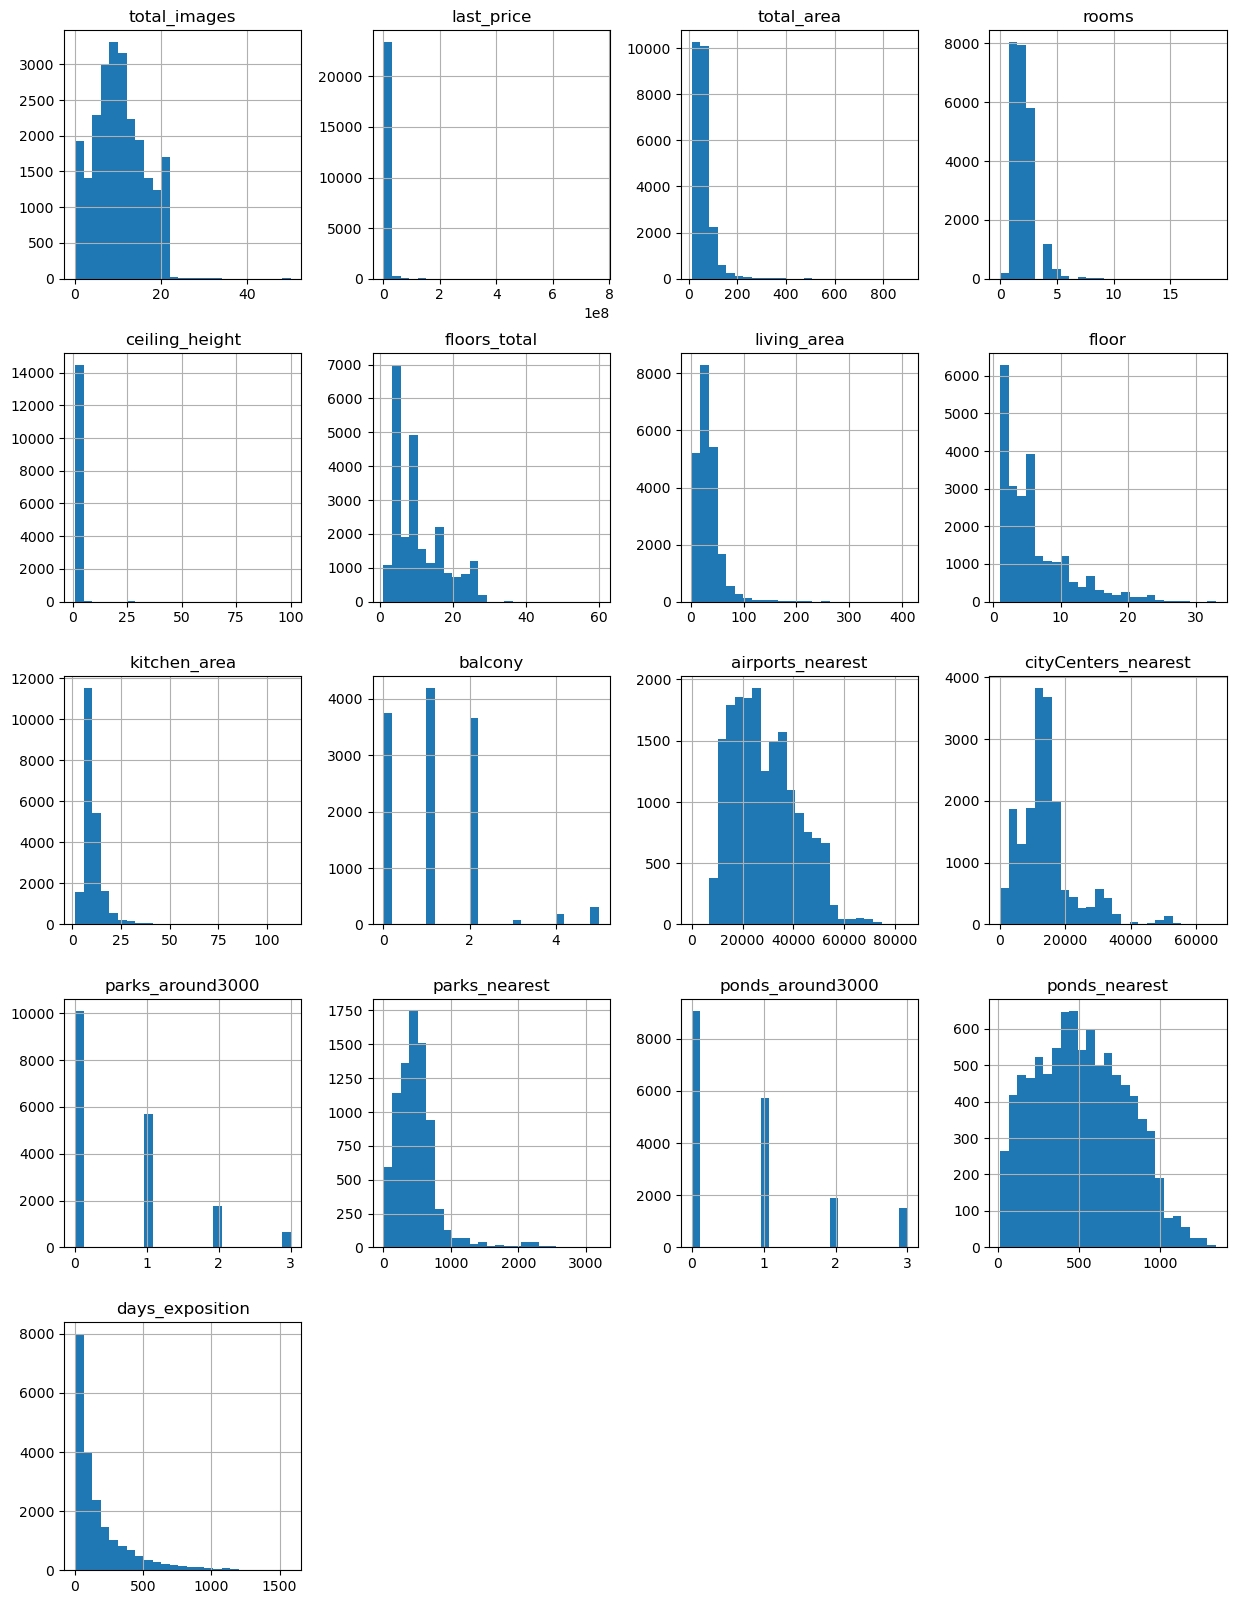

In [3]:
data.hist(figsize=(15, 20), bins = 25);

### Предобработка данных

**Начну предобработку данных с заполнения пропущенных значений там, где это возможно.**

Рассмотрю ближе данные о высоте потолков в домах. Отдельно представлю гистограмму в более понятном виде, ограничив её по высоте и добавив некоторое число корзин:

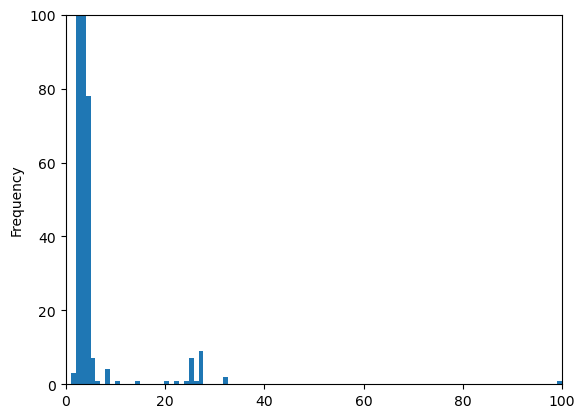

In [4]:
data['ceiling_height'].plot.hist(xlim = (0, data['ceiling_height'].max()), ylim = (0, 100),bins = 100);

На графике видно небольшое количество выбросов, поэтому пропущенные значения буду заменять **медианной** высотой потолков в целях избежания влияния выброса на данные

In [5]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

Рассмотрю данные по тем столбцам, где присутствуют пропуски.:

В данных можно заметить выбросы, которые могли бы повлиять на среднее значение. Чтобы этого избежать заполним медианным значением пропуски по столбцам **floors_total, balcony, living_area, kitchen_area, days_exposition**

In [6]:
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median())
data['balcony'] = data['balcony'].fillna(data['balcony'].median())
data['living_area'] = data['living_area'].fillna(data['living_area'].median())
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())
data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median())

Остальные параметры, такие как удаленность от аэропорта, удаленность от центра и т.п. заполнять не станем.
Проверим, не осталось ли незаполненных значений в категориях, где их быть не должно:

In [7]:
qp = pd.DataFrame({'characteristics':data.isna().sum().index, 'nans':data.isna().sum().values})
qp['percentage'] = qp['nans'] / len(data)
qp

,characteristics,nans,percentage
0,total_images,0,0.000000
1,last_price,0,0.000000
2,total_area,0,0.000000
3,first_day_exposition,0,0.000000
4,rooms,0,0.000000
5,ceiling_height,0,0.000000
6,floors_total,0,0.000000
7,living_area,0,0.000000
8,floor,0,0.000000
9,is_apartment,20924,0.882906


Все необходимые пропуски были устранены.

Теперь изменю некоторые типы данных в датафрейме. Все изменения будут с float на int. Они коснуться столбцов: 
* floors_total 
* balcony
* parks_around3000
* ponds_around3000

Это связано с тем, что данные в этих столбцах **не** могут принимать дробные значения, а только целочисленные

Столбец days_exposition округлим и также приведем к типу int. Данные изменятся совершенно незначительно, однако станут удобнее для восприятия и анализа

In [8]:
data['days_exposition'] = data['days_exposition'].round(decimals = 0)
data[['parks_around3000', 'ponds_around3000', 'balcony', 'floors_total', 'days_exposition']] = data[['parks_around3000', 'ponds_around3000', 'balcony', 'floors_total', 'days_exposition']].astype('Int64')
data = data.replace(pd.NA, np.nan)


Далее изменю тип данных в столбце **first_day_exposition** с str на datetime

In [9]:
import datetime as dt
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

Теперь устраним неявные дубликаты в названиях населенных пунктов. В основном это одни и те же названия с указанием "поселок/посёлок/деревня" и т.п. и без него. Поэтому избавлюсь от них:

In [10]:
data['locality_name'] = data['locality_name'].replace(to_replace={'посёлок ':'', 
                                                                  'деревня ':'', 
                                                                  'поселок ':'',
                                                                  'городского типа ':'', 
                                                                  'городской ':''}, regex=True)
data['locality_name'] = data['locality_name'].replace(to_replace={'имени Свердлова':'Поселок имени Свердлова'}, regex=True)
data['locality_name'].value_counts().head()

locality_name
Санкт-Петербург    15721
Мурино               590
Кудрово              472
Шушары               440
Всеволожск           398
Name: count, dtype: int64

Удалим строки, где в каких-либо значениях присутствуют выбросы. Для этого определим в каких столбцах они вообще присутствуют. Если рассмотреть гистограммы, то аномальные значения есть в столбцах:
* total_area
* rooms
* last_price
* ceiling_height
* floors_total
* last_price
* living_area
* kitchen_area
* parks_nearest, ponds_nearest, airports_nearest

Стоит обратить внимание, чтобы в итоге какое-либо floor не оказалось больше total_floors в строке. Нельзя жить этажем выше крыши. Также стоит пояснить почему я удаляю большие данные данные в parks_nearest, ponds_nearest, airports_nearest и не удаляю очень маленькие. Свод правил по градостроительству СП 42.13330.2016, действующий на момент выполнения проекта НЕ регламентирует минимальные отступы от жилого дома до парковой зоны, пруда или аэропорта (при согласовании с аэропортом разрешено строить жилые здания на любом удалении от границ аэропорта). А при исследовании онлайн-карты я выяснил, что расстояние от самой удаленной точки самого удаленного от аэропорта населенного пункта из списка locality_name меньше чем максимальное значение airports_nearest, встречающееся в данных.

Удалим 1% последних значений и добавим особое условие для этажности. Это позволит отбросить невозможные значения, а редкие оставить.

In [11]:
listed = ['total_area', 
             'living_area', 
             'last_price', 
             'last_price', 
             'ceiling_height', 
             'floors_total', 
             'last_price', 
             'kitchen_area', 
             'parks_nearest', 
             'ponds_nearest', 
             'airports_nearest']    
for value in listed:
        data = data.drop(data[(data[value] >= np.percentile(data[value], 99))].index)
#Отдельное условие, которое уберет квартиры, находящиеся выше крыши здания

data = data.drop(data[(data['floor'] > data['floors_total'])].index)

Теперь оценим обновленные данные. Действительно, теперь максимальные значения вполне себе адекватны и подходят для дальнейшего анализа

In [12]:
data[['total_area', 
            'living_area', 
             'ceiling_height', 
             'floors_total', 
             'last_price', 
             'kitchen_area', 
             'parks_nearest', 
             'ponds_nearest', 
             'airports_nearest']].describe()

,total_area,living_area,ceiling_height,floors_total,last_price,kitchen_area,parks_nearest,ponds_nearest,airports_nearest
count,21648.000000,21648.000000,21648.000000,21648.0,2.164800e+04,21648.000000,6943.000000,7890.000000,16289.000000
mean,54.463118,31.210874,2.667597,10.578067,5.094752e+06,9.543058,493.707907,530.725602,28745.579655
std,20.409571,13.484185,0.155355,6.33766,2.688328e+06,3.328985,338.217361,275.809850,12805.964763
min,12.000000,2.000000,1.000000,1.0,4.300000e+05,1.300000,1.000000,13.000000,0.000000
25%,39.300000,19.000000,2.600000,5.0,3.350000e+06,7.000000,293.000000,315.000000,18023.000000
50%,50.000000,30.000000,2.650000,9.0,4.500000e+06,9.100000,457.000000,516.000000,26982.000000
75%,65.000000,39.000000,2.700000,16.0,6.200000e+06,11.000000,616.000000,739.000000,37434.000000
max,196.000000,94.900000,3.490000,25.0,1.617717e+07,25.340000,3190.000000,1344.000000,84869.000000


Теперь данные очищены от большей части пропусков, а также от аномальных значений и выбросов. Предобработку данных можно считать завершенной.

### Посчитайте и добавьте в таблицу новые столбцы

Добавим в таблицу цену за один квадратный метр. В дальнейшем будет необходимым выяснить факторы, влияющие на стоимость квадратного метра. 

In [13]:
data['sqm_cost'] = data['last_price'] / data['total_area']

Полезной метрикой будет и день недели, в которое было выставлено объявление. Возможно время публикации так или иначе влияет на стоимость квартир. Для дальнейшего удобства анализа каждый день недели будет обозначен своим уникальным индексом, где:
* 0 = Понедельник
* 1 = Вторник

**...**
* 6 = Воскресенье

In [14]:
data['weekday_index'] = data['first_day_exposition'].apply(lambda x: x.weekday())

Аналогичные действию выше я проделаю в отношении месяца и года, в которые было впервые выставленно объявление

In [15]:
data['month_index'] = data['first_day_exposition'].dt.month
data['year_index'] = data['first_day_exposition'].dt.year

Теперь определю тип этажа. Наверняка особым спросом пользуются крайние этажи (первый и последний) как требующий наименьших трудозатрат, чтобы на него поднятся и максимально удаленный от шума и городской пыли соответственно. Добавим категоризацию этажей в нашу таблицу.

In [16]:
data['floor_type'] = ''
data['floor_type'] = np.where(data['floor'] == 1, 'первый', data['floor_type'])
data['floor_type'] = np.where(data['floor'] == data['floors_total'], 'последний', data['floor_type'])
data['floor_type'] = np.where(data['floor_type'] == '', 'другой', data['floor_type'])
data['floor_type_id'] = ''
data['floor_type_id'] = np.where(data['floor'] == 1, 1, data['floor_type_id'])
data['floor_type_id'] = np.where(data['floor_type'] == 'последний' , 3, data['floor_type_id'])
data['floor_type_id'] = np.where(data['floor_type'] == 'другой', 2, data['floor_type_id'])
data['floor_type_id'] = data['floor_type_id'].astype('float32')

Также для удобства восприятия данных переведем расстояние до центра города из метров в километры:

In [18]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000).astype('Int64')

Теперь датафрейм пополнился метриками, что будут полезны при дальнейшем исследовательском анализе. Можно переходить непосредственно к нему:

In [19]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,sqm_cost,weekday_index,month_index,year_index,floor_type,floor_type_id,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,...,2,755.0,95,120370.370370,3,3,2019,другой,2.0,16
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,NaN,...,0,NaN,81,82920.792079,1,12,2018,первый,1.0,19
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,NaN,...,2,574.0,558,92785.714286,3,8,2015,другой,2.0,14
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,NaN,...,<NA>,NaN,55,95065.789474,0,9,2018,другой,2.0,<NA>
7,5,7915000.0,71.6,2019-04-18,2,2.65,24,30.0,22,NaN,...,0,NaN,95,110544.692737,3,4,2019,другой,2.0,12


### Проведем исследовательский анализ данных

Перед там как анализировать данные я их опишу. Это необходимо, поскольку мы добавили несколько новых метрик и избавились от выбросов и аномальных значений до этого.

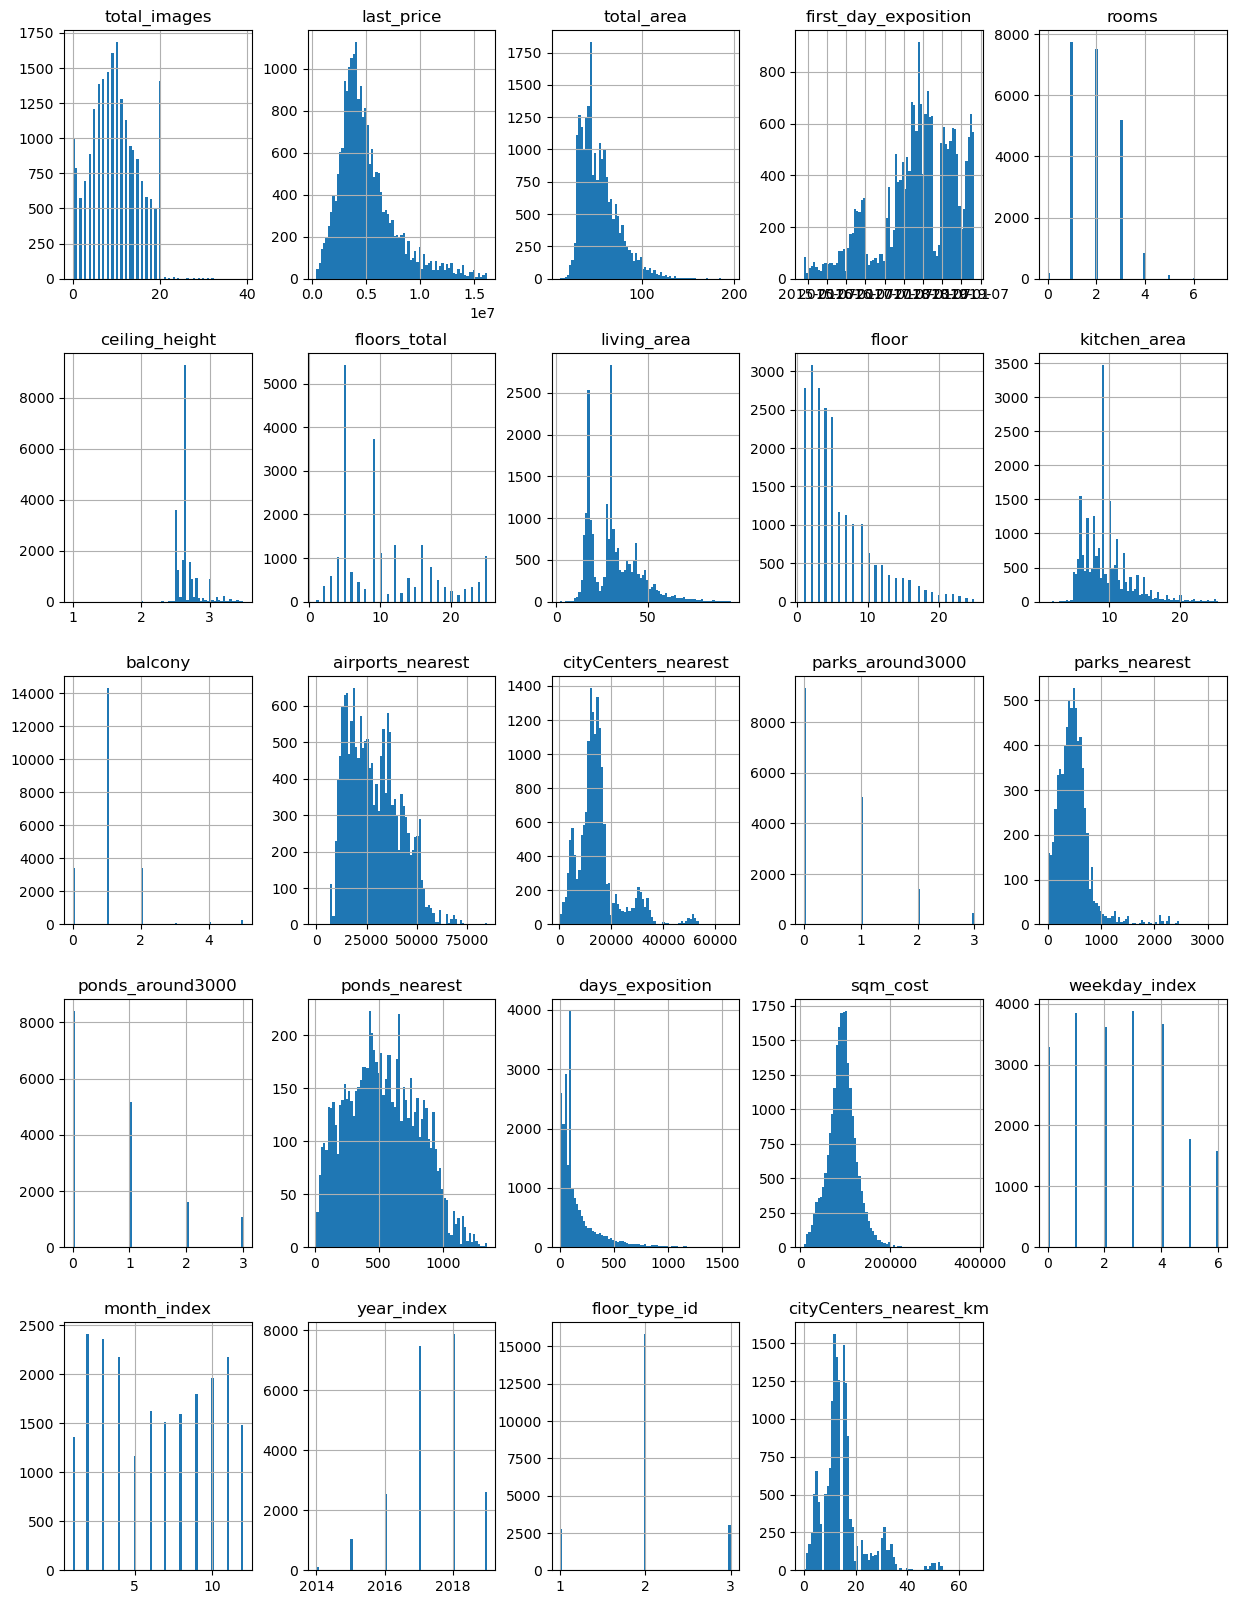

In [20]:
data.hist(figsize = (15, 20), bins = 75);

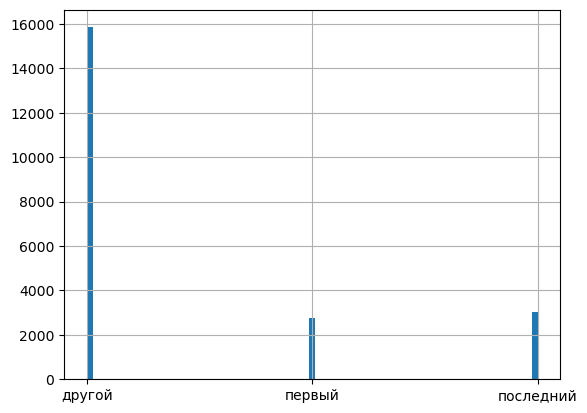

In [21]:
data['floor_type'].hist(bins = 75);

О чем же говорят данные, очищенные от выбросов, а также пополнившиеся новыми метриками?

1) **Жилая площадь:** На графике видно несколько пиков (20, 30 и 40 квадратных метров). Возможно это пики связаны с количеством комнат в квартирах. С каждой новой комнатой на графике жилой площади отмечается скачок.

2) **Общая площадь:** На графике можно отметить распределение результатов близкое к нормальному. В основной массе это квартиры 40-60 квадратных метров.

3) **Площадь кухни:** На графике заметен пик в районе 11 квадратных метров. Возможно кухни такого размера наиболее распространенные у застройщиков. Более того, возможно на рынке преобладает типовая застройка, где кухни имеют именно такой размер.

4) **Цена объекта:** На графике можно отметить нормальное распределение и что он коррелирует с графиком цены за квадратный метр. Можно заметить, что самые популярные квартиры - это квартиры стоимости ниже среднего. 

5) **Количество комнат:** Из графика следует, что однокомнатные и двухкомнатные квартиры практически эквивалентно популярны. Преобладание на рынке однокомнатных квартир совпадает с наблюдением о том, что квартиры дешевле среднего пользуются наибольшим спросом.

6) **Высота потолков:** На графике есть заметный скачок в районе значения 2.7 метров. Это неудивительно, ведь высота потолков в многоквартирных домах в основе своей близка к данному значению

7) **Этаж квартиры:** Чем меньше этаж - тем охотнее продают квартиру. Это может быть связано с тем, что жизнь на нижних этажах несет в себе большие риски затопления и пр.

8) **Тип этажа квартиры:** Гистограмма этой метрики говорит нам, что квартиры непосредственно на первом этаже продают неохотнее, чем любые другие. Наверняка с ними не хотят расставаться пожилые жильцы, которым сложно подниматься высоко по лестнице и семьи с маленькими детьми, которые в противном случае были бы вынуждены высоко поднимать коляски, санки и пр.

9) **Общее количество этажей**: Согласно графику этой метрики, самое продаваемое жилье находится в обычных пятиэтажных и девятиэтажных зданиях. Скорее всего это "хрущовки" и "брежневки", в которых все еще проживает очень много человек. Далее видны пики у более многоэтажной застройки. Возможно многоэтажные жилые дома - это тренд последних лет среди застройщиков.

10) **Расстояние до центра города:** Основной пик этого графика приходится на расстояние 7-9 км до центра города. Обычно в крупных городах (коим Санкт-Петербург является) именно на этом удалении от центра располагается массовая жилая застройка среднего класса. Другой пик графика приходится на квартиры на удалении 2-3 км от центра города. Это можно объяснить тем, что в выборке участвует не только Санкт-Петербург, но и прилегающие маленькие города. Логичным будет предположить, что в маленьких городах расстояние от жилых домов до географического центра будет меньше.

11) **Расстояние до аэропорта:** На графике можно увидеть, что между 0 расстоянием от аэропрта и резким скачком есть "пропасть". Возможно это связано с тем, что аэропорт находится ЗА чертой города, а вне географических границ города в целом находится мало квартир. Стоит отметить и тот факт, что чем ближе к аэропорту - тем охотнее люди продают свои квартиры. Возможно им не нравится шум от самолетов и удаленность от центра города.

12) **Расстояние до ближайшего парка:** Гистограмма этой метрики отличается нормальным распределением. Квартиры возле парка продают реже, чем на среднем удалении. Логичным будет предположение, что люди неохотно расстаются с недвижимостью, располагающейся близко к удобному мету для прогулок и отдыха со свежим воздухом.

13) **День и месяц публикации объявления:** В основном объявления публикуются по будням осенью и особенно зимой. Возможно, зимний период наиболее популярен в связи с получением основной массой рабочих годовых премий и, как следствие, появлением свободных финансов.

Начнем анализ с оценки времени, которое по статистике требуется для продажи квартиры. Выведу медианное и среднее значение продажи, а также визуализирую данные при помощи гистограммы:

Среднеее значение времени для продажи: 165.51224131559496 
Медианное значение времени для продажи: 95.0


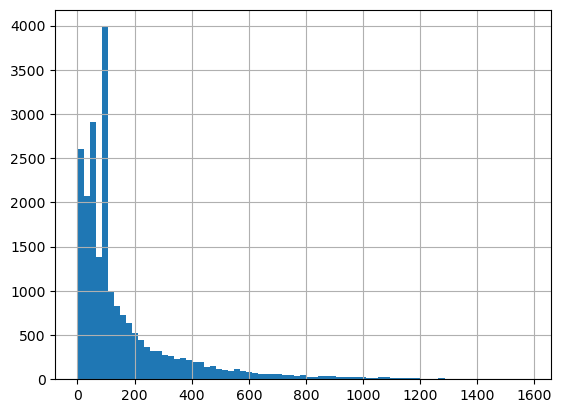

In [22]:
data['days_exposition'].hist(bins = 75);
print('Среднеее значение времени для продажи:', data['days_exposition'].mean(),  '\nМедианное значение времени для продажи:', data['days_exposition'].median())

На гистограмме видна причина по которой среднее и медианное значение так различаются: это резкий скачок в районе 180 дней для продажи. Необычно долгими продажами будем считать те продажи, что заняли более 800 дней (на гистограмме мы видим резкое нижение кол-ва объявлений после этой отметки), а необычно бытрыми те, что заняли 20 и менее дней. На гистограмме это самый первый столбец.

В среднем же продажа квартиры занимает 176-177 дней

Пришло время оценить от чего зависит стоимость квартиры. Наверняка, чем квартира больше - тем она дороже стоит. Проверим данную гипотезу

Корреляция между площадью квартиры и её стоимостью составляет 74 %


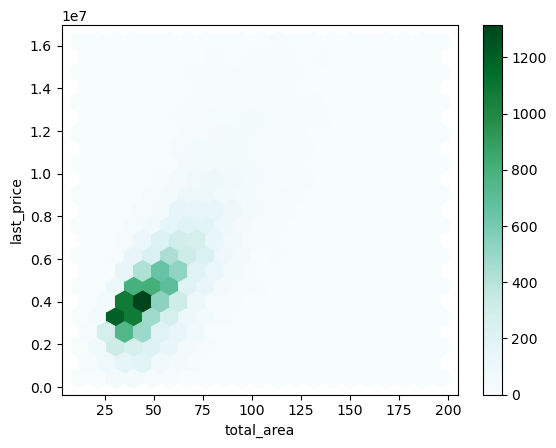

In [23]:
data.plot.hexbin('total_area', 'last_price', gridsize = 20)
print('Корреляция между площадью квартиры и её стоимостью составляет',round(data['total_area'].corr(data['last_price'])*100), '%')

Гипотеза подтвердилась. Стоимость квартиры действительно очень сильно зависит от её площади.

Оценим влияние таких параметров как **living_area, kitchen_area, rooms и датой** на стоимость квартиры. Для первых двух параметров обратимся к матрице рассеяния: 

Корреляция между пареметром living_area и её стоимостью составляет 59 %
Корреляция между пареметром kitchen_area и её стоимостью составляет 51 %


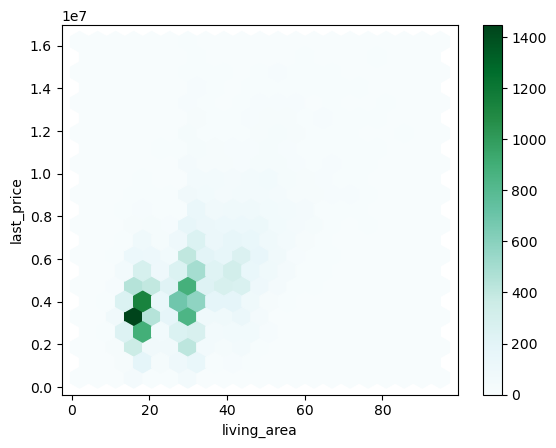

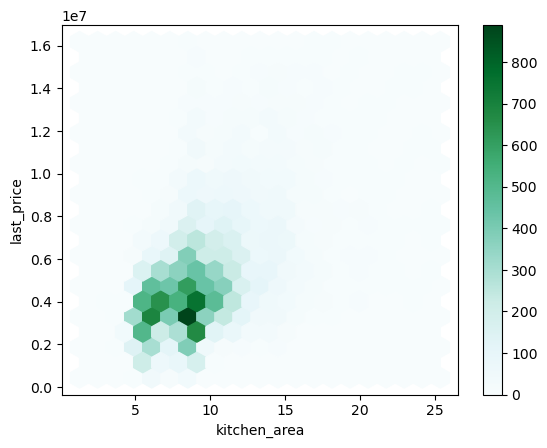

In [24]:
lst = ['living_area', 'kitchen_area']
for dat in lst:
    data.plot.hexbin(dat, 'last_price', gridsize = 20)
    print('Корреляция между пареметром', dat, 'и её стоимостью составляет',round(data[dat].corr(data['last_price'])*100), '%')

Благодаря построению еще нескольких графиков корреляции мы выяснили, что площадь жилой зоны и кухни оказывают определенное влияние на стоимость квартиры, однако критическим или решающим это значение не назовешь.

Проверим, как влияет среднюю стоимость квартиры количество комнат в ней. Для этого использую столбчатую диаграмму

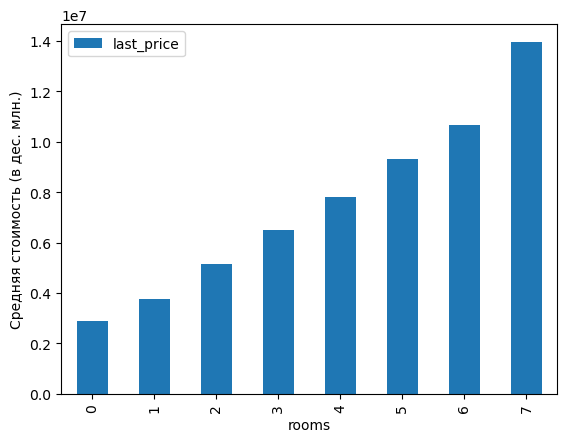

In [25]:
repos = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = 'mean')
repos.plot(kind = 'bar', ylabel = 'Средняя стоимость (в дес. млн.)');

Неудивительно, но чем больше в квартире комнат - тем она дороже. 

Теперь оценим влияние на стоимость квартиры времени, в которое было размещено объявление о продаже

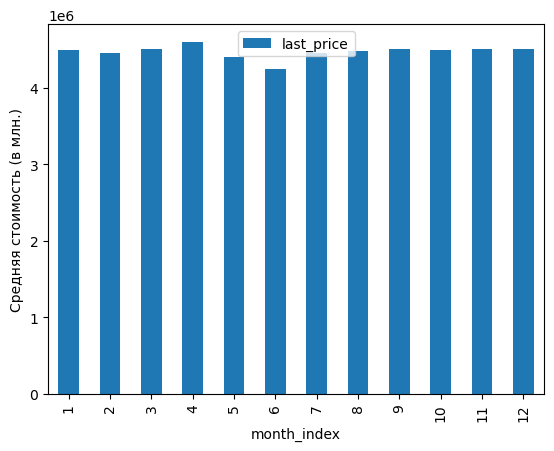

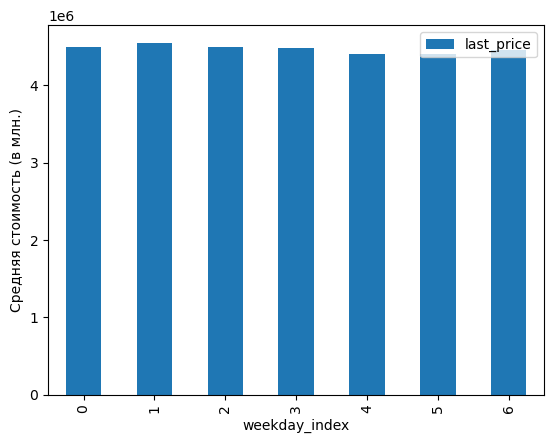

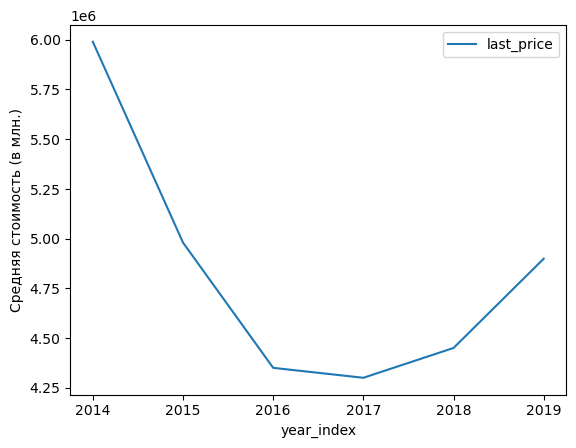

In [26]:
timecheck = ['month_index', 'weekday_index']
for kind in timecheck:
    timepos = data.pivot_table(index = kind, values = 'last_price', aggfunc = 'median')
    timepos.plot(kind = 'bar', ylabel = 'Средняя стоимость (в млн.)');
    
timepos = data.pivot_table(index = 'year_index', values = 'last_price', aggfunc = 'median')
timepos.plot(kind = 'line', ylabel = 'Средняя стоимость (в млн.)');

Какие выводы мы можем сделать из графиков выше?

* Месяц продажи **незначительно** влияет на стоимость квартир. Например, в июне они чуть дешевле, а апреле - чуть дороже
* Дент, в который выложено объявления **не имеет** влияния на стоимость квартиры
* С 2014 года квартиры значительно подешевели, однако после 2017 начали вновь дорожать. В 2019 году (конец выборки) медианная стоимость квартир была примерно между максимумом (в 2014 году) и минимумом (в 2017 году).

Построим сводную таблицу по типу этажа, на котором продается квартира. Посмотрим среднее и медианное значение:

In [27]:
quaso = data.pivot_table(index = 'floor_type', aggfunc = ['mean', 'median'], values = 'last_price')
quaso.columns = ['Средняя цена квартир', 'Медианная цена квартир']
quaso

,Средняя цена квартир,Медианная цена квартир
floor_type,,
другой,5.323191e+06,4650000.0
первый,4.212714e+06,3825000.0
последний,4.703925e+06,4100000.0


А теперь построим столбчатую диаграмму. На ней будет видно квартиры на каких этажах ценятся на рынке наиболее сильно.

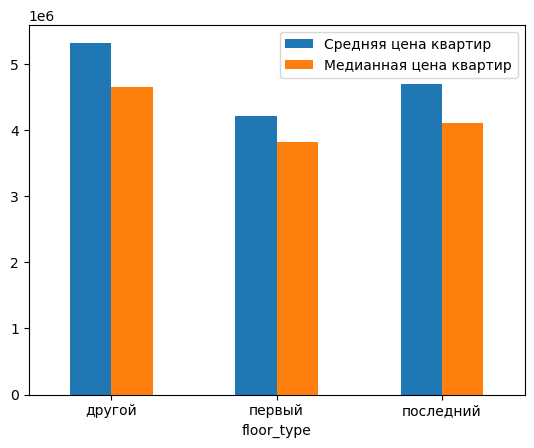

In [28]:
quaso.plot(kind = 'bar', rot = 0);

Квартиры на первом и последнем этаже не ценятся на рынке так, как квартиры на прочих этажах. При том разница в средней цене незначительная, а потому можно утверждать, что этаж квартиры влияет, но слабо на цену продажи недвижимости.

Чтобы обобщить данные, полученные в этом блоке, я выведу на экран список метрик, имеющих наибольшую корреляцию со стоимостью квартир

In [29]:
list_for_graph = ['total_area',
                  'living_area',
                  'kitchen_area',
                  'rooms']
correlation = pd.Series()
for entry in list_for_graph:
    correlation['Процент корреляции по ' + entry] = data['last_price'].corr(data[entry])*100
#    print(f'Корреляция между ценой и {entry} составляет: {correlation:0.2%}')
correlation.sort_values(ascending = False)
correlation

Процент корреляции по total_area      73.795199
Процент корреляции по living_area     59.250327
Процент корреляции по kitchen_area    50.838440
Процент корреляции по rooms           46.946966
dtype: float64

Подводя итоги можно сказать следующее:
* Наибольшее влияние на стоимость квартиры оказывает её общая площадь
* В меньшей степени влияют жилая площадь и площадь кухни, количество комнат
* Наименьшее влияние оказывает время публикации объявления

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений:

In [30]:
top_cities = data.pivot_table(index = 'locality_name', aggfunc = ['count', 'mean'], values = ['last_price', 'sqm_cost'])
print('Таблица количества объявлений в различных городах')
top_cities = top_cities[[('count', 'last_price'), ('mean', 'sqm_cost')]].sort_values(by = ('count', 'last_price'), ascending = False).head(10)
top_cities = top_cities.rename(columns = {'last_price': 'Коичество объявлений', 'count' : '', 'mean': '', 'sqm_cost': 'Средняя стоимость квадратного метра'})
top_cities.index.name = 'Город'
top_cities

Таблица количества объявлений в различных городах


Коичество объявлений Средняя стоимость квадратного метра
Город                                                                   
Санкт-Петербург                14037                       107314.783011
Мурино                           500                        86115.564291
Кудрово                          464                        95330.775045
Шушары                           432                        78815.233041
Всеволожск                       390                        66935.354838
Пушкин                           341                       101323.186524
Колпино                          336                        75396.399554
Гатчина                          301                        68678.048688
Выборг                           224                        57600.450572
Парголово                        205                        85864.088307

Ранее мы посчитали расстояние до центра в километрах. Теперь выделим квартиры в Санкт-Петербурге и вычислим среднюю цену каждого километра. Опишу, как стоимость объектов зависит от расстояния до центра города.

In [31]:
# "Отсеим" все города, кроме Санкт-Петербурга

spb = data.query('locality_name == "Санкт-Петербург"')
spb

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,sqm_cost,weekday_index,month_index,year_index,floor_type,floor_type_id,cityCenters_nearest_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.0,8,NaN,...,2,755.0,95,120370.370370,3,3,2019,другой,2.0,16
2,10,5196000.0,56.00,2015-08-20,2,2.65,5,34.3,4,NaN,...,2,574.0,558,92785.714286,3,8,2015,другой,2.0,14
7,5,7915000.0,71.60,2019-04-18,2,2.65,24,30.0,22,NaN,...,0,NaN,95,110544.692737,3,4,2019,другой,2.0,12
9,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.6,7,NaN,...,0,NaN,289,88524.590164,6,2,2017,другой,2.0,15
10,5,5050000.0,39.60,2017-11-16,1,2.67,12,20.3,3,NaN,...,2,553.0,137,127525.252525,3,11,2017,другой,2.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23688,19,9200000.0,101.00,2019-04-01,3,3.05,15,63.0,12,NaN,...,0,NaN,23,91089.108911,0,4,2019,другой,2.0,14
23689,13,3550000.0,35.30,2018-02-28,1,2.86,15,16.3,4,NaN,...,2,652.0,29,100566.572238,2,2,2018,другой,2.0,16
23690,3,5500000.0,52.00,2018-07-19,2,2.65,5,31.0,2,NaN,...,0,NaN,15,105769.230769,3,7,2018,другой,2.0,6
23691,11,9470000.0,72.90,2016-10-13,2,2.75,25,40.3,7,NaN,...,1,806.0,519,129903.978052,3,10,2016,другой,2.0,4


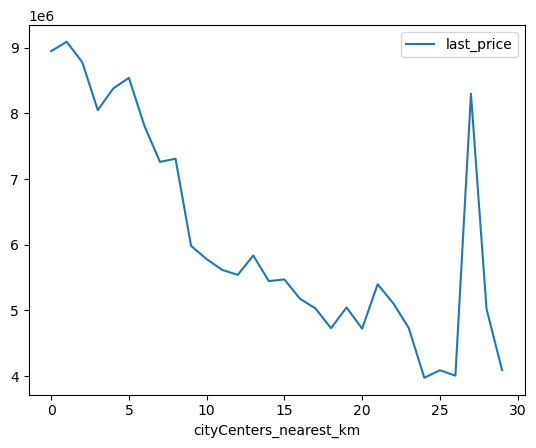

In [32]:
# Проведем расчет средней стоимости километра до центра города

qwe = spb.pivot_table(index = 'cityCenters_nearest_km', aggfunc = 'mean', values = 'last_price')
qwe
qwe.plot(kind = 'line', alpha = 1);

При помощи полученной линейной диаграммы можно оценивать среднюю стоимость каждого километра удаления от центра города. Общая тенденция такова, что чем дальше от центра - тем дешевле стоят квартиры. Есть резкий скачок на удалении 26-27 км от города. Скорее всего это связано с расположением там элитной загородной недвижимостью, которая отличается высокой ценой.

### Общий вывод

Датасет содержит все необходимые данные для определения рыночной стоимости объектов недвижимости. 

Из них **общая площадь квартиры** оказывает наибольшее влияние на её стоимость. В меньшей степени влияющими на стоимость недвижимости оказались такие метрики как **количество комнат, жилая площадь и площадь кухни**. Фактически не оказывающим влияния на стоимость квартиры оказался фактор даты публикации оного.

У нас появилось представление о **типичном объекте недвижимости**. Это одно- или двухкомнатная квартира в пятиэтажном или девятиэтажном здании, находящаяся ни на первом, ни на последнем этаже. Таковая стоит около 3.5 млн. рублей, имеет 2.6 метровые потолки и занимает пощадь в 42-50 квадратных метров. До центра города от такой квартиры примерно 10-13 километров, да аэропорта - в районе 20 км, а до парка меньше километра.

В среднем квартиры продаются за **160-190** дней с момента публикации. Самое большое количество предложений находится в **Санкт-Петербурге**. Они же и самые дорогие - **107 314** рублей за один квадратный метр дома, а самым доступным жильем из топ-10 крупных городов Ленинградской области обладает **Выборг** с средней ценою в **57 600** рублей за квадратный метр.

В будущем, для лучшего понимания рынка недвижимости было бы полезно изучить класс жилья (эконом, премиум, бизнес), район города, где находится жилье, а также застройщика, который предоставляет здания.